### Якимчук О.

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

Завантажуємо дані, ти дивимося на перші 5 рядків:

In [3]:
# df = pd.read_csv('/content/gdrive/My Drive/task.csv', sep=';',  encoding = "ISO-8859-1")
df = pd.read_csv('task.csv', sep=';',  encoding = "ISO-8859-1")
df.head()

,Unnamed: 0,ISO,UA,Cql,Ie,Iec,Is
0,Albania,ALB,Àëáàí³ÿ,"0,97392353","0,605347614","0,538672856","0,510112666"
1,Algeria,DZA,Àëæèð,"0,782134498","0,58721932","0,348159396","0,497985576"
2,Angola,AGO,Àíãîëà,"0,372343539","0,27439361","0,332117384","0,346906645"
3,Argentina,ARG,Àðãåíòèíà,"0,883830062","0,699685109","0,28199471","0,518820368"
4,Armenia,ARM,Â³ðìåí³ÿ,"1,016498793","0,718326882","0,535647909","0,486498047"


Далі видалємо перші 3 колонки, вони нам не потрібні на даному етапі, якщо потім знадобляться, ми зможемо їх додати по індексу

In [4]:
df = df.drop(['Unnamed: 0', 'ISO', 'UA'], axis=1)
df.head()

,Cql,Ie,Iec,Is
0,"0,97392353","0,605347614","0,538672856","0,510112666"
1,"0,782134498","0,58721932","0,348159396","0,497985576"
2,"0,372343539","0,27439361","0,332117384","0,346906645"
3,"0,883830062","0,699685109","0,28199471","0,518820368"
4,"1,016498793","0,718326882","0,535647909","0,486498047"


Дивимося загальну інформацію по датасету:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
Cql    132 non-null object
Ie     132 non-null object
Iec    132 non-null object
Is     132 non-null object
dtypes: object(4)
memory usage: 4.2+ KB


як бачимо, в нас 132 рядки, немає NaN-ів, проте є проблема, що тип даних - object, проблема зв'язана з python, він не розпізнає float, який розділений комою, наступна дія це пофіксить:

In [6]:
def replace_comma_to_dot(raw):
    for j in range(len(raw)):
        raw[j] = str(raw[j]).replace(',', '.')
    return raw

df = df.apply(replace_comma_to_dot)

for i in df.columns:
    df[i] = pd.to_numeric(df[i])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 4 columns):
Cql    132 non-null float64
Ie     132 non-null float64
Iec    132 non-null float64
Is     132 non-null float64
dtypes: float64(4)
memory usage: 4.2 KB


Як можемо побачити, тепер в нас тип даних float :)

Далі замінимо всі від'ємні значення, якщо такі є, на додатні:

In [7]:
def abs_dataframe(raw):
    for j in range(len(raw)):
        if raw[j] < 0:
            raw[j] = np.absolute(raw[j])
    return raw

df = df.apply(abs_dataframe)

Тепер побудуємо кореляційну матрицю:

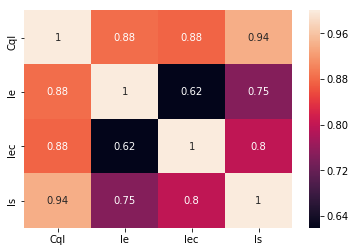

In [8]:
corr = df.corr()
sb.heatmap(corr, annot=True)

Побудуємо "ящики з вусами", щоб виявити аутлаєрів, якщо такі є

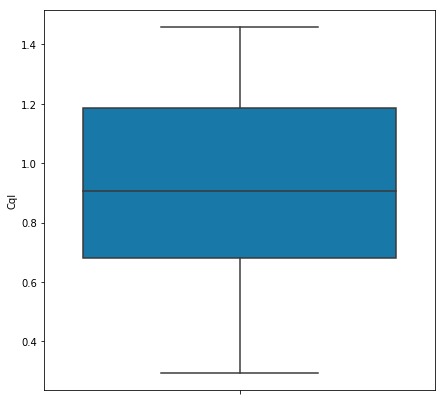

In [9]:
plt.figure(figsize=(7, 7))
sb.boxplot(y='Cql',data=df,palette='winter')

по змінній "Cql" аутлаєрів немає 

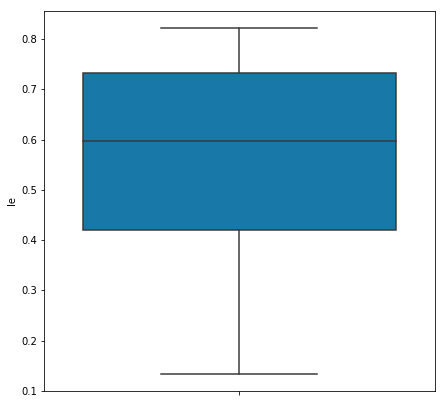

In [10]:
plt.figure(figsize=(7, 7))
sb.boxplot(y='Ie',data=df,palette='winter')

по змінній "Ie" аутлаєрів немає

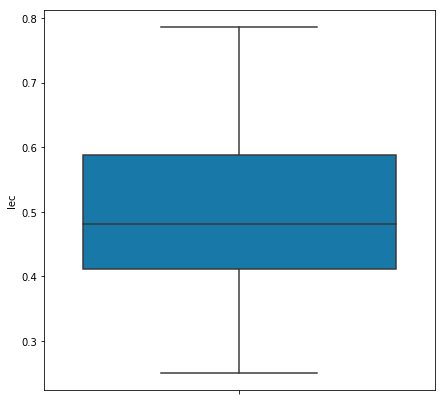

In [11]:
plt.figure(figsize=(7, 7))
sb.boxplot(y='Iec',data=df,palette='winter')

по змінній "Iec" аутлаєрів немає

розіб'ємо дані на навчальну і тестову вибірки, таким чином, щоб тестова становила 20% від всіх даних

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Is',axis=1), 
                                                    df['Is'], test_size=0.20, 
                                                    random_state=101)

## Лінійна регресія

Спробуємо натренувати лінійну регресію

#### Для оцінки будемо використовувати метрику $R^2$


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [15]:
lr = LinearRegression(n_jobs=-1)
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2_score(y_test, y_pred)

0.9732314547130143

Як бачимо, отримали досить непоганий результат, для перевірки його адекватності проведемо крос-валідацію:

In [16]:
scores = cross_val_score(lr, df.drop('Is', axis=1), df['Is'], scoring='r2', cv=5)
scores

array([0.96211109, 0.97732049, 0.96406087, 0.96860884, 0.94903708])

Знайдемо загальний результат для лінійної регресії:

In [17]:
linear_score = np.mean(scores)
linear_score

0.9642276719438145

## Поліноміальна регресія

Розглянемо модель поліноміальної регресії:

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

для початку підберемо оптимальну степінь полінома. Для цього побудуємо моделі для поліномів степеней від 1 до 10 і виберемо найкращий:

In [19]:
score_degree = []
for i in range(1, 11):
    model = Pipeline([('poly', PolynomialFeatures(degree=i)), 
                      ('linear', LinearRegression(fit_intercept=False))])
    model = model.fit(X_train.iloc[:], y_train)
    y_pred_p = model.predict(X_test)
    score_degree.append(r2_score(y_test, y_pred_p))
print(score_degree)
print('\nOptimal degree:', score_degree.index(max(score_degree)) + 1)

[0.9732314547130141, 0.9684516587699648, 0.9961252421223253, 0.9962119565807405, 0.9986067235746545, 0.99624887977612, 0.9974862745510519, 0.9957675009950453, 0.9948974430040253, 0.9943653249607916]

Optimal degree: 5


Проведемо кросвалідацію для оптимальної моделі:

In [20]:
model = Pipeline([('poly', PolynomialFeatures(degree=5)), 
                  ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(X_train.iloc[:], y_train)

scores_p = cross_val_score(model, df.drop('Is', axis=1), df['Is'], scoring='r2', cv=5)
scores_p

array([0.97489124, 0.99986188, 0.99856954, 0.9998344 , 0.99889621])

Знайдемо загальний результат для поліноміальної регресії:

In [21]:
linear_score = np.mean(scores_p)
linear_score

0.9944106521476194

### Висновок: 
Як бачимо, результат поліноміальної регресії вищий ніж результат лінійної регресії, що означає, що дані в датасеті, швидше за все, залежні не лінійно. Також існує ризик, що степінь поліному не оптимальна, оскільки в нас немає ніяких даних про взаємозв'язки в датасеті.

Проте яка модель настправді краща буде видно в перевірці на тестових даних.

## Перевірка

потрібно провести таку саму підготовку даних

In [22]:
df_test = pd.read_csv('test_task.csv', sep=';',  encoding = "ISO-8859-1")
df_test.head()

,Unnamed: 0,ISO,UA,Cql,Ie,Iec,Is
0,Togo,TGO,Òîãî,"0,45349807","0,216806252","0,368234721","0,433950896"
1,Tunisia,TUN,Òóí³ñ,"0,899461952","0,659123985","0,418255976","0,514745939"
2,Turkey,TUR,Òóðå÷÷èíà,"0,859283802","0,498840185","0,509228185","0,499453094"
3,Uganda,UGA,Ó´àíäà,"0,571284014","0,362945628","0,448731923","0,375726313"
4,Ukraine,UKR,Óêðà¿íà,"0,802203636","0,689164485","0,303554874","0,462744168"


In [23]:
df_test = df_test.drop(['Unnamed: 0', 'ISO', 'UA'], axis=1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
Cql    5 non-null object
Ie     5 non-null object
Iec    5 non-null object
Is     5 non-null object
dtypes: object(4)
memory usage: 240.0+ bytes


In [24]:
df_test = df_test.apply(replace_comma_to_dot)

for i in df_test.columns:
    df_test[i] = pd.to_numeric(df_test[i])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
Cql    5 non-null float64
Ie     5 non-null float64
Iec    5 non-null float64
Is     5 non-null float64
dtypes: float64(4)
memory usage: 240.0 bytes


In [25]:
df_test = df_test.apply(abs_dataframe)

In [26]:
test_x = df_test.drop('Is', axis=1)
test_y = df_test['Is']

Перевірка лінійної регресії:

In [27]:
lin_pred = lr.predict(test_x)
r2_score(test_y, lin_pred)

0.8992481243591328

Перевірка поліноміальної регресії:

In [28]:
polin_pred = model.predict(test_x)
r2_score(test_y, polin_pred)

0.9872627961056255

## Висновки

Тепер можна з впевенністю сказати, що дані в датасеті залежать не лінійно, саме тому результат поліноміальної регресії набагато кращий від результату лінійної регресії.